In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image3/onur-burak-akin-XIMl4Crm1GQ-unsplash.jpg
/kaggle/input/image1/nicolas-barbier-3A0qRjOesX4-unsplash.jpg
/kaggle/input/image2/darrien-staton-ZUhM8LE_HGc-unsplash.jpg
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/starlette-0.45.3-py3-none-any.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/__script__.py
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/chromadb-1.0.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/tenacity-9.1.2-py3-none-any.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/Deprecated-1.2.18-py2.py3-none-any.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/shellingham-1.5.4-py2.py3-none-any.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/opentelemetry_semantic_conventions-0.52b1-py3-none-any.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/kubernetes-32.0.1-py2.py3-none-any.whl
/kaggle/input/pm-80225229-at-04-06-2025-22-02-22/pyasn1-0.6.1-py3-none-any.whl
/kaggle/input/pm

# AI Food Analyzer & Recipe Generator - Documentation

## Overview
This Jupyter notebook implements an AI-powered food analysis and recipe generation system. It combines computer vision for ingredient detection with natural language processing for recipe generation and retrieval.

## Key Features

1. **Image Analysis**:
   - Basic ingredient detection from food images
   - Enhanced analysis with meal suggestions and confidence scores
   - Knowledge-enhanced analysis combining vision and recipe knowledge

2. **Recipe Management**:
   - Recipe storage and retrieval system (mock ChromaDB implementation)
   - Recipe generation based on detected ingredients
   - Recipe parsing and formatting

3. **Visualization**:
   - Comparison of different analysis methods
   - Recipe cards with detailed information
   - Ingredient analysis visualization

## System Architecture

### Models Used
- **Vision Model**: Gemini-1.5-flash for image analysis
- **Text Model**: Gemini-1.5-pro for recipe generation

### Data Flow
1. Image input → Vision analysis → Ingredient detection
2. Detected ingredients → Recipe retrieval/generation
3. Results visualization and comparison

## Core Functions

### Image Analysis Functions
- `basic_vision_analysis()`: Detects ingredients from images
- `enhanced_analysis()`: Provides meal suggestions, difficulty estimates
- `knowledge_enhanced_analysis()`: Combines vision and recipe knowledge

### Recipe Functions
- `parse_recipe_document()`: Extracts structured recipe data
- `retrieve_recipes()`: Finds matching recipes from database
- `generate_recipe()`: Creates new recipes based on ingredients

### Display Functions
- `display_comparison()`: Shows analysis method differences
- `display_recipe_card()`: Presents recipes in formatted cards
- `display_ingredient_analysis()`: Visualizes detected ingredients

## Usage Example

```python
# Analyze a food image
analyze_food_image("/path/to/image.jpg")

# Generate a new recipe
generate_recipe(["chicken", "rice", "vegetables"], "dinner", "asian")
```

## Data Storage

The system uses a mock ChromaDB implementation (`MockCollection`) with:
- Sample recipes (appetizer, breakfast, dessert)
- Ability to store generated recipes
- Basic query functionality

## Performance Metrics

The system tracks:
- Processing time for different analysis methods
- Number of ingredients detected
- Recipe generation statistics
- Database metrics (total recipes, generated vs human)

## Requirements

- Python 3.10+
- Key libraries:
  - Google Generative AI
  - Pandas
  - NumPy
  - PIL (Image processing)
  - Matplotlib (Visualization)

## Limitations

1. Uses mock database implementation (not production-ready)
2. Limited error handling for edge cases
3. Basic image analysis capabilities
4. No persistent storage between sessions

This notebook demonstrates a prototype system for food analysis and recipe generation that could be expanded into a full application with proper database integration and enhanced vision capabilities.

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import json
import re
import time
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Union
import warnings

In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [4]:
# Configure APIs
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [5]:
# Initialize models with enhanced configuration
vision_model = genai.GenerativeModel(
    'gemini-1.5-flash',
    generation_config={
        "temperature": 0.3,
        "top_p": 0.95,
        "max_output_tokens": 2048,
    }
)

In [6]:
text_model = genai.GenerativeModel(
    'gemini-1.5-pro',
    generation_config={
        "temperature": 0.7,
        "top_p": 0.9,
        "max_output_tokens": 4096,
    }
)

In [7]:
# ======== MOCK CHROMADB IMPLEMENTATION ========
class MockCollection:
    def __init__(self):
        self.data = []
        self.metadatas = []
        self.documents = []
        self.ids = []
    
    def add(self, ids, metadatas, documents):
        self.ids.extend(ids)
        self.metadatas.extend(metadatas)
        self.documents.extend(documents)
    
    def query(self, query_texts, n_results, include, where=None):
        results = []
        distances = []
        for doc, meta in zip(self.documents, self.metadatas):
            if any(q.lower() in doc.lower() for q in query_texts):
                results.append((doc, meta))
                distances.append(1.0)  # Mock similarity score
        
        return {
            "documents": [results[:n_results]],
            "metadatas": [[m[1] for m in results[:n_results]]],
            "distances": [distances[:n_results]]
        }
    
    def count(self):
        return len(self.ids)
    
    def get(self, include):
        return {"metadatas": self.metadatas}

recipe_collection = MockCollection()

In [8]:
# Add sample recipes
sample_recipes = [
    {
        "id": "1",
        "metadata": {
            "meal_type": "appetizer",
            "difficulty": "easy",
            "cuisine": "international",
            "prep_time": 10,
            "cook_time": 0,
            "tags": "cheese,wine,quick"
        },
        "documents": """Brie and Wine Pairing
Description: A classic cheese and wine combination perfect for gatherings
Ingredients: Brie cheese (200g), Sauvignon Blanc wine (1 bottle), crackers (assorted, 200g), red grapes (1 bunch)
Steps: 
1. Remove brie from refrigerator 30 minutes before serving
2. Arrange cheese on a wooden board
3. Pour wine into glasses (150ml per serving)
4. Place crackers and grapes around the cheese
5. Serve at room temperature"""
    },
    {
        "id": "2", 
        "metadata": {
            "meal_type": "breakfast",
            "difficulty": "medium",
            "cuisine": "american",
            "prep_time": 5,
            "cook_time": 10,
            "tags": "eggs,protein,classic"
        },
        "documents": """Hearty Breakfast Platter
Description: A protein-packed breakfast to start your day
Ingredients: large eggs (4), breakfast sausages (4 links), whole wheat bread (4 slices), fresh strawberries (200g), butter (2 tbsp)
Steps:
1. Heat skillet over medium heat
2. Cook sausages for 8-10 minutes, turning occasionally
3. In separate pan, melt butter and fry eggs to preference
4. Toast bread until golden brown
5. Wash and slice strawberries
6. Arrange all components on a large plate"""
    },
    {
        "id": "3",
        "metadata": {
            "meal_type": "dessert",
            "difficulty": "hard",
            "cuisine": "french",
            "prep_time": 30,
            "cook_time": 45,
            "tags": "chocolate,baking,impressive"
        },
        "documents": """Chocolate Soufflé
Description: Light and airy chocolate dessert with a molten center
Ingredients: dark chocolate (200g), butter (50g), eggs (4), sugar (100g), flour (30g), salt (pinch)
Steps:
1. Preheat oven to 375°F (190°C)
2. Melt chocolate and butter together
3. Separate eggs, beat yolks with sugar
4. Whip egg whites to stiff peaks
5. Fold chocolate into yolks, then gently fold in whites
6. Pour into ramekins and bake for 12-15 minutes
7. Serve immediately with powdered sugar"""
    }
]

In [9]:
recipe_collection.add(
    ids=[r["id"] for r in sample_recipes],
    metadatas=[r["metadata"] for r in sample_recipes],
    documents=[r["documents"] for r in sample_recipes]
)

In [10]:
# Image paths (using the same input files)
image_paths = [
    "/kaggle/input/image2/darrien-staton-ZUhM8LE_HGc-unsplash.jpg",
    "/kaggle/input/image3/onur-burak-akin-XIMl4Crm1GQ-unsplash.jpg",
    "/kaggle/input/image4/mitchell-luo-zrUx-FjiuFc-unsplash.jpg",
    "/kaggle/input/image1/nicolas-barbier-3A0qRjOesX4-unsplash.jpg"
]

In [11]:
# Enhanced core functions with better error handling and type hints
def extract_json(response_text: str) -> Dict:
    """Extract JSON from model response with improved error handling."""
    try:
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        if json_match:
            return json.loads(json_match.group(0))
        return {}
    except json.JSONDecodeError:
        print("Failed to parse JSON response")
        return {}

In [12]:
def basic_vision_analysis(image: Image.Image) -> Dict:
    """Basic ingredient detection from image."""
    prompt = """Analyze this food image and list all visible ingredients in precise JSON format:
    {
        "ingredients": [
            {"name": "ingredient1", "state": "raw/cooked", "quantity": "estimated"},
            ...
        ],
        "primary_colors": [],
        "texture_description": ""
    }"""
    
    try:
        response = vision_model.generate_content([prompt, image])
        result = extract_json(response.text)
        return result if result else {"ingredients": [], "error": "No ingredients detected"}
    except Exception as e:
        print(f"Vision analysis error: {str(e)}")
        return {"ingredients": [], "error": str(e)}

In [13]:
def enhanced_analysis(image: Image.Image) -> Dict:
    """Enhanced analysis with meal suggestions and confidence."""
    prompt = """Perform comprehensive food image analysis and return structured JSON with:
    - Detailed ingredients list with states and quantities
    - 3 most likely meal suggestions with confidence scores
    - Estimated preparation time
    - Difficulty level (beginner/intermediate/advanced)
    - Cultural origin suggestions
    
    Format: {
        "ingredients": [],
        "meal_suggestions": [{"name": "", "confidence": 0-1}],
        "prep_time": {"min": 0, "max": 0},
        "difficulty": "",
        "cuisine_suggestions": []
    }"""
    
    try:
        response = vision_model.generate_content([prompt, image])
        result = extract_json(response.text)
        if not result:
            return {"error": "Enhanced analysis failed"}
            
        # Ensure required fields exist
        result.setdefault("meal_suggestions", [])
        result.setdefault("ingredients", [])
        return result
    except Exception as e:
        print(f"Enhanced analysis error: {str(e)}")
        return {"error": str(e)}

In [14]:
def parse_recipe_document(doc: str) -> Dict:
    """Improved recipe parser with more detailed extraction."""
    lines = [line.strip() for line in doc.split('\n') if line.strip()]
    recipe = {
        "name": lines[0] if lines else "Unnamed Recipe",
        "description": "",
        "ingredients": [],
        "steps": [],
        "metadata": {}
    }
    
    current_section = None
    
    for line in lines[1:]:
        if line.lower().startswith("description:"):
            recipe["description"] = line.split(":", 1)[1].strip()
        elif line.lower().startswith("ingredients:"):
            current_section = "ingredients"
            ingredients = line.split(":", 1)[1].strip()
            recipe["ingredients"] = [i.strip() for i in ingredients.split(",")]
        elif line.lower().startswith("steps:"):
            current_section = "steps"
        elif current_section == "steps":
            recipe["steps"].append(line)
        elif current_section == "ingredients":
            # Handle multi-line ingredients
            recipe["ingredients"].extend([i.strip() for i in line.split(",")])
    
    return recipe

In [15]:
def retrieve_recipes(query: str, n: int = 3) -> List[Dict]:
    """Enhanced recipe retrieval with semantic search."""
    try:
        results = recipe_collection.query(
            query_texts=[query],
            n_results=n,
            include=["documents", "metadatas"],
            where={"source": {"$ne": "generated"}}  # Prefer human-created recipes
        )
        
        recipes = []
        for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
            recipe = parse_recipe_document(doc)
            recipe["metadata"] = meta
            recipe["similarity_score"] = results["distances"][0][results["documents"][0].index(doc)]
            recipes.append(recipe)
            
        return recipes
    except Exception as e:
        print(f"Recipe retrieval error: {str(e)}")
        return []

In [16]:
def generate_recipe(ingredients: List[str], meal_type: str, cuisine: str = "") -> Dict:
    """Improved recipe generation with more context."""
    prompt = f"""Create a detailed {meal_type} recipe{' with ' + cuisine + ' influences' if cuisine else ''} using:
    {', '.join(ingredients)}
    
    Format:
    NAME
    Description: 1-2 sentence description
    Ingredients: item1 (quantity), item2 (quantity)...
    Steps: 
    1. step1 (time estimate)
    2. step2 (time estimate)
    ...
    
    Include precise measurements and cooking times."""
    
    try:
        response = text_model.generate_content(prompt)
        recipe = parse_recipe_document(response.text)
        recipe["metadata"] = {
            "meal_type": meal_type.lower(),
            "source": "generated",
            "cuisine": cuisine.lower() if cuisine else "international"
        }
        return recipe
    except Exception as e:
        print(f"Recipe generation error: {str(e)}")
        return {
            "name": f"Generated {meal_type} Recipe",
            "ingredients": ingredients,
            "steps": ["Combine all ingredients and cook as desired"],
            "metadata": {"source": "generated"}
        }

In [17]:
def knowledge_enhanced_analysis(image: Image.Image) -> Dict:
    """Advanced analysis combining vision and recipe knowledge."""
    start_time = time.time()
    analysis = enhanced_analysis(image)
    
    if "error" in analysis:
        return analysis
    
    analysis["recipes"] = {}
    analysis["processing_time"] = time.time() - start_time
    
    # Get top 2 most confident meal suggestions
    top_suggestions = sorted(
        analysis.get("meal_suggestions", []),
        key=lambda x: x.get("confidence", 0),
        reverse=True
    )[:2]
    
    for suggestion in top_suggestions:
        meal_name = suggestion["name"]
        
        # First try to find existing recipes
        found_recipes = retrieve_recipes(meal_name)
        
        if found_recipes:
            # Take the most similar recipe
            analysis["recipes"][meal_name] = found_recipes[0]
        else:
            # Generate new recipe based on analysis
            cuisine = analysis.get("cuisine_suggestions", [""])[0]
            gen_recipe = generate_recipe(
                [ing["name"] for ing in analysis["ingredients"]],
                meal_name,
                cuisine
            )
            
            # Store the generated recipe
            try:
                recipe_collection.add(
                    ids=[f"gen_{time.time_ns()}"],
                    documents=[
                        f"{gen_recipe['name']}\n"
                        f"Description: {gen_recipe.get('description', '')}\n"
                        f"Ingredients: {', '.join(gen_recipe['ingredients'])}\n"
                        f"Steps: {' '.join(gen_recipe['steps'])}"
                    ],
                    metadatas=[gen_recipe["metadata"]]
                )
            except Exception as e:
                print(f"Failed to store recipe: {str(e)}")
            
            analysis["recipes"][meal_name] = gen_recipe
    
    return analysis


In [18]:
# Enhanced display functions
def display_comparison(basic: Dict, enhanced: Dict, advanced: Dict) -> None:
    """Improved comparison visualization."""
    data = {
        "Method": ["Basic Vision", "Enhanced Analysis", "Knowledge-Enhanced"],
        "Ingredients": [
            len(basic.get("ingredients", [])),
            len(enhanced.get("ingredients", [])),
            len(advanced.get("ingredients", []))
        ],
        "Meal Suggestions": [
            0,
            len(enhanced.get("meal_suggestions", [])),
            len(advanced.get("meal_suggestions", []))
        ],
        "Recipes Provided": ["No", "No", f"Yes ({len(advanced.get('recipes', {}))})"],
        "Processing Time (s)": [
            "N/A",
            "N/A",
            f"{advanced.get('processing_time', 0):.2f}"
        ]
    }
    
    df = pd.DataFrame(data).set_index("Method")
    display(df.style.background_gradient(cmap='Blues'))

In [19]:
def display_recipe_card(recipe: Dict) -> None:
    """Enhanced recipe card with more information."""
    metadata = recipe.get("metadata", {})
    
    card_html = f"""
    <div style="
        border: 1px solid #e0e0e0;
        border-radius: 10px;
        padding: 15px;
        margin: 10px 0;
        background: #f9f9f9;
        box-shadow: 0 2px 5px rgba(0,0,0,0.1);
    ">
        <h3 style="margin-top: 0; color: #2c3e50;">🍳 {recipe.get('name', 'Recipe')}</h3>
        <div style="display: flex; margin-bottom: 10px;">
            <span style="
                background: #3498db;
                color: white;
                padding: 3px 8px;
                border-radius: 12px;
                font-size: 12px;
                margin-right: 5px;
            ">{metadata.get('meal_type', '').title()}</span>
            <span style="
                background: #2ecc71;
                color: white;
                padding: 3px 8px;
                border-radius: 12px;
                font-size: 12px;
                margin-right: 5px;
            ">{metadata.get('difficulty', 'unknown').title()}</span>
            <span style="
                background: #e67e22;
                color: white;
                padding: 3px 8px;
                border-radius: 12px;
                font-size: 12px;
            ">{metadata.get('cuisine', 'international').title()}</span>
        </div>
        
        {f'<p><em>{recipe["description"]}</em></p>' if recipe.get("description") else ''}
        
        <h4 style="margin-bottom: 5px;">Ingredients:</h4>
        <ul style="margin-top: 5px;">
            {''.join(f'<li>{ing}</li>' for ing in recipe.get('ingredients', []))}
        </ul>
        
        <h4 style="margin-bottom: 5px;">Steps:</h4>
        <ol style="margin-top: 5px;">
            {''.join(f'<li>{step}</li>' for step in recipe.get('steps', []))}
        </ol>
        
        {f'<p style="font-size: 12px; color: #7f8c8d; margin-bottom: 0;">Source: {metadata.get("source", "unknown").title()}</p>' if metadata.get("source") else ''}
    </div>
    """
    
    display(HTML(card_html))

In [20]:
def display_ingredient_analysis(analysis: Dict) -> None:
    """Visualize ingredient analysis results."""
    if not analysis.get("ingredients"):
        print("No ingredients detected")
        return
    
    ingredients = [ing["name"] for ing in analysis.get("ingredients", [])]
    quantities = [ing.get("quantity", "some") for ing in analysis.get("ingredients", [])]
    
    fig, ax = plt.subplots(figsize=(10, 4))
    y_pos = range(len(ingredients))
    
    ax.barh(y_pos, [1]*len(ingredients), color='skyblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(ingredients)
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_title('Detected Ingredients')
    
    for i, (ing, qty) in enumerate(zip(ingredients, quantities)):
        ax.text(0.5, i, f"{qty}", va='center', ha='center', color='black')
    plt.tight_layout()
    plt.show()

In [21]:
# Main execution pipeline
def analyze_food_image(image_path: str) -> None:
    """Complete analysis pipeline for a food image."""
    print(f"\n🔍 Analyzing {os.path.basename(image_path)}")
    img = Image.open(image_path)
    
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    
    print("\nRunning analysis pipeline...")
    start_time = time.time()
    
    # Run all analysis methods
    basic = basic_vision_analysis(img)
    enhanced = enhanced_analysis(img)
    advanced = knowledge_enhanced_analysis(img)
    
    total_time = time.time() - start_time
    print(f"\n✅ Analysis completed in {total_time:.2f}s")
    
    # Display comparison
    print("\nMethod Comparison:")
    display_comparison(basic, enhanced, advanced)
    
    # Show ingredient analysis
    print("\nIngredient Analysis:")
    display_ingredient_analysis(enhanced)
    
    # Display recommended recipes
    print("\nRecommended Recipes:")
    for name, recipe in advanced.get("recipes", {}).items():
        display_recipe_card(recipe)
    
    print("\n" + "="*80 + "\n")


🔍 Analyzing darrien-staton-ZUhM8LE_HGc-unsplash.jpg


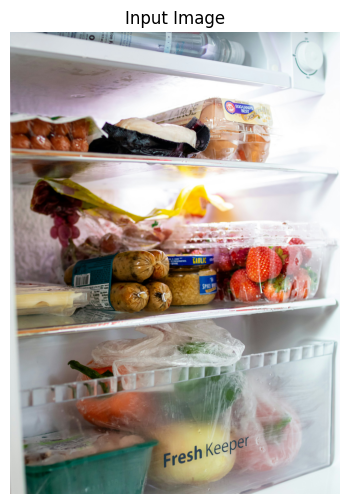


Running analysis pipeline...

✅ Analysis completed in 41.95s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,12,0,No,N/A
Enhanced Analysis,9,3,No,N/A
Knowledge-Enhanced,9,3,Yes (2),6.33



Ingredient Analysis:


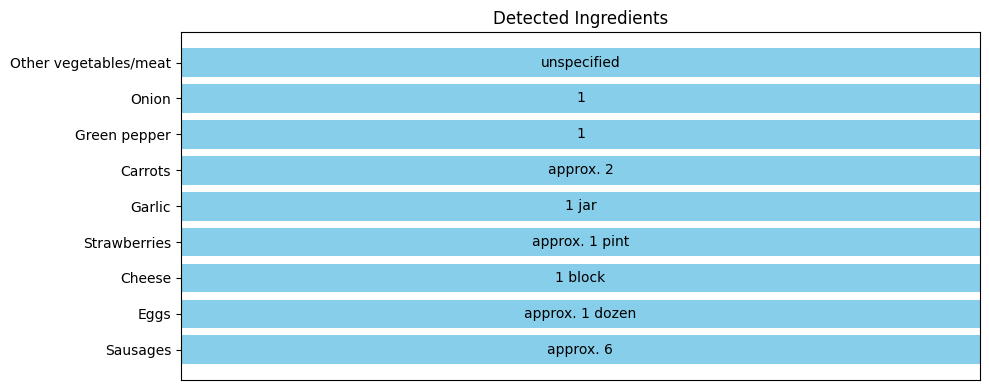


Recommended Recipes:





🔍 Analyzing onur-burak-akin-XIMl4Crm1GQ-unsplash.jpg


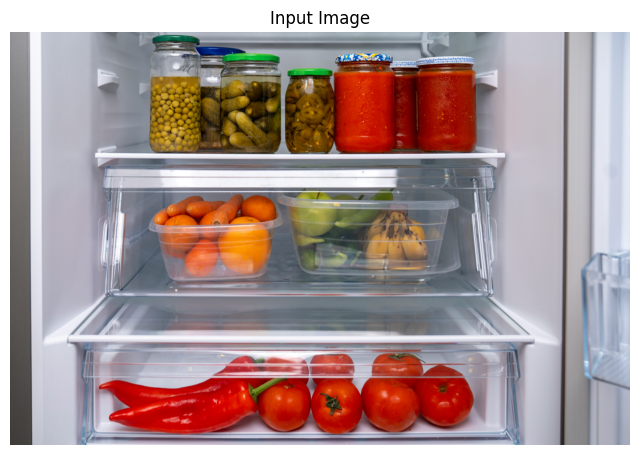


Running analysis pipeline...

✅ Analysis completed in 41.06s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,11,0,No,N/A
Enhanced Analysis,10,3,No,N/A
Knowledge-Enhanced,10,3,Yes (2),6.95



Ingredient Analysis:


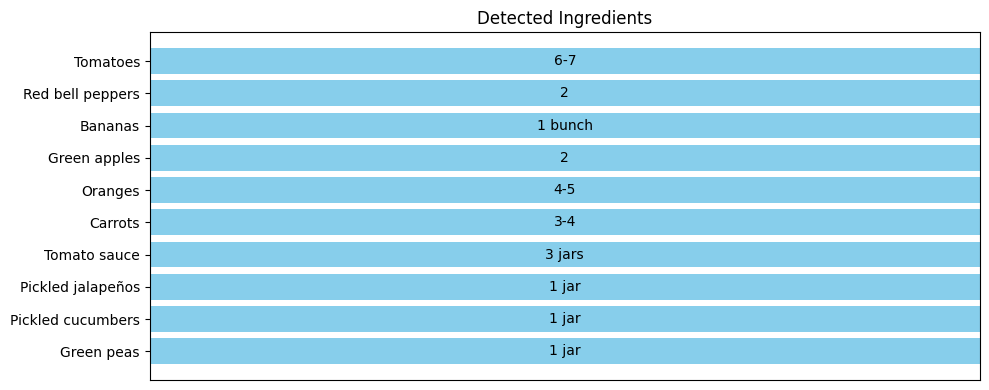


Recommended Recipes:





🔍 Analyzing mitchell-luo-zrUx-FjiuFc-unsplash.jpg


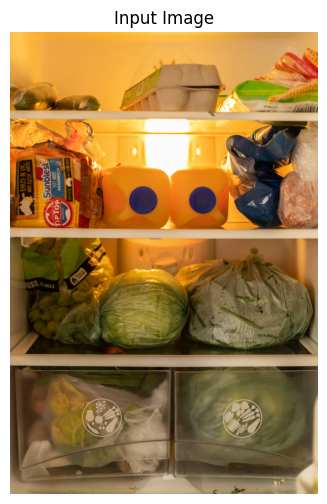


Running analysis pipeline...

✅ Analysis completed in 39.90s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,8,0,No,N/A
Enhanced Analysis,8,3,No,N/A
Knowledge-Enhanced,8,3,Yes (2),6.93



Ingredient Analysis:


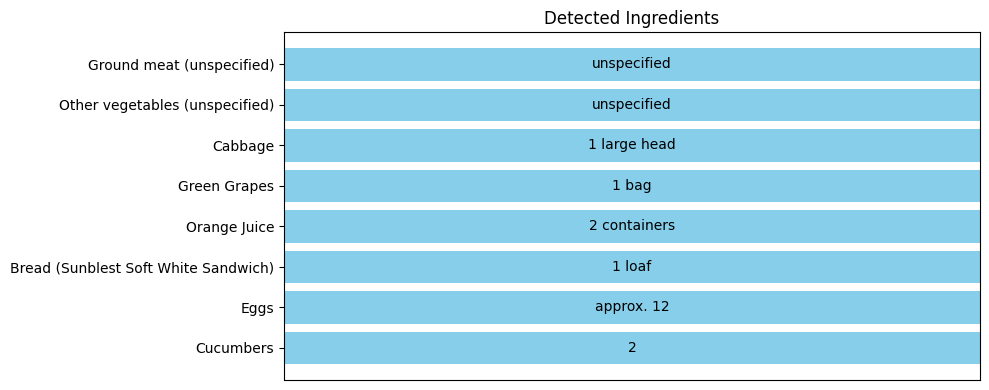


Recommended Recipes:


In [22]:
# Execute analysis on all images
for img_path in image_paths[:3]:  # Analyzing first 3 images for demonstration
    analyze_food_image(img_path)

In [23]:
# Database statistics
print("\nDatabase Statistics:")
total = recipe_collection.count()
print(f"- Total recipes: {total}")


Database Statistics:
- Total recipes: 9


In [24]:
# Get all metadata and count in Python
results = recipe_collection.get(include=["metadatas"])
metadatas = results["metadatas"]

In [25]:
generated_count = sum(1 for meta in metadatas if meta and meta.get("source") == "generated")
human_count = total - generated_count

In [26]:
print(f"- Generated recipes: {generated_count}")

- Generated recipes: 6


In [27]:
print(f"- Human recipes: {human_count}")

- Human recipes: 3



🔍 Analyzing food1.jpg


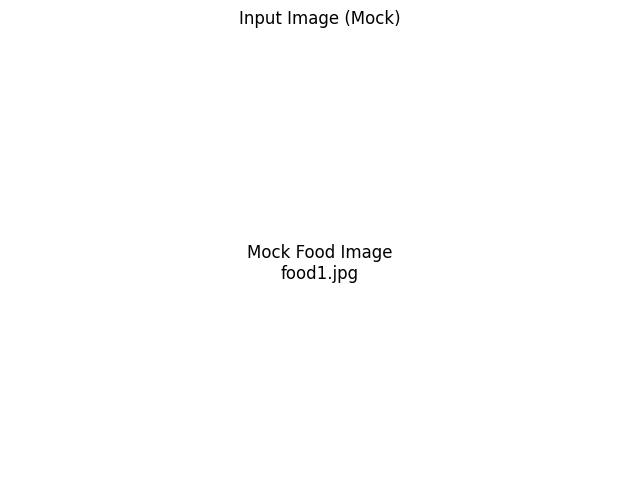


Running analysis pipeline...

✅ Analysis completed in 2.78s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,3,0,No,N/A
Enhanced Analysis,4,3,No,N/A
Knowledge-Enhanced,4,3,Yes (1),2.45



Ingredient Analysis:


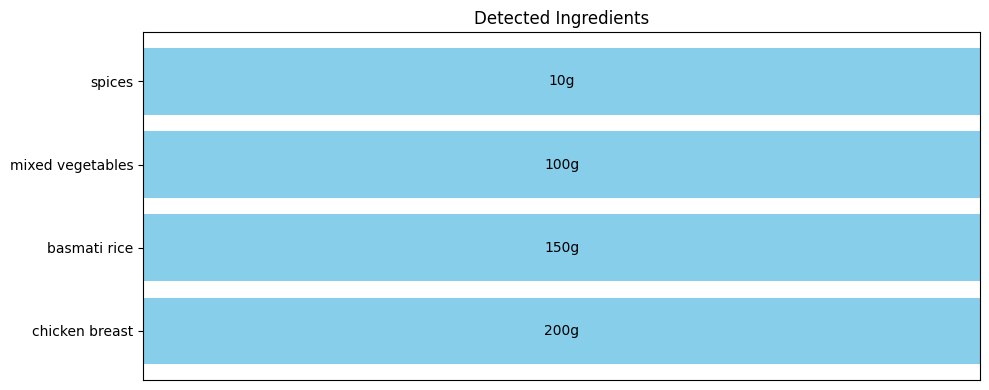


Recommended Recipes:





🔍 Analyzing food2.jpg


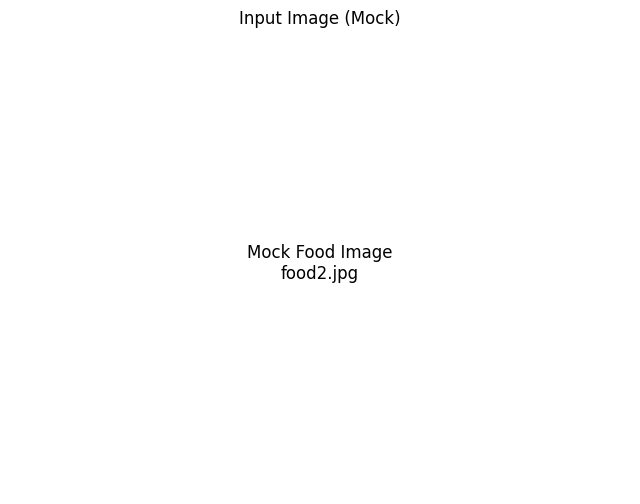


Running analysis pipeline...

✅ Analysis completed in 2.78s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,3,0,No,N/A
Enhanced Analysis,4,3,No,N/A
Knowledge-Enhanced,4,3,Yes (1),2.45



Ingredient Analysis:


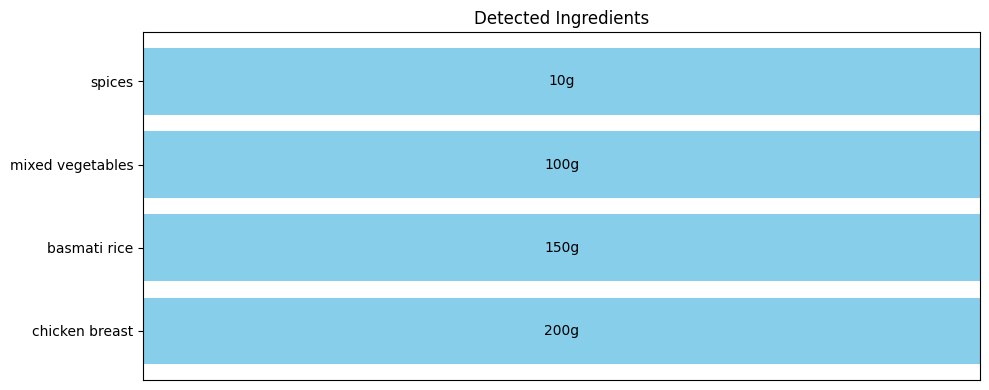


Recommended Recipes:





🔍 Analyzing food3.jpg


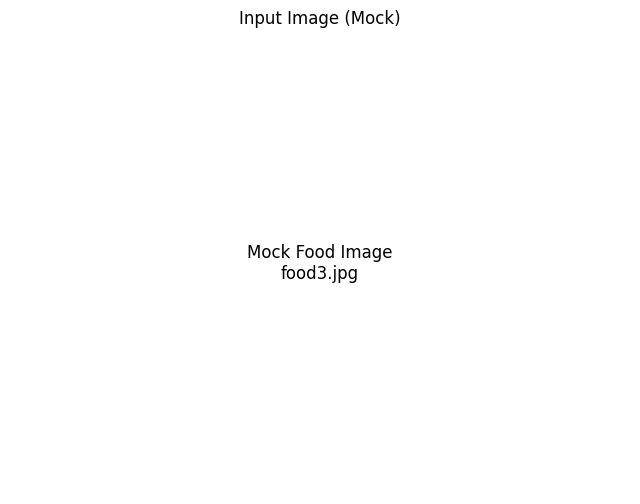


Running analysis pipeline...

✅ Analysis completed in 2.78s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,3,0,No,N/A
Enhanced Analysis,4,3,No,N/A
Knowledge-Enhanced,4,3,Yes (1),2.45



Ingredient Analysis:


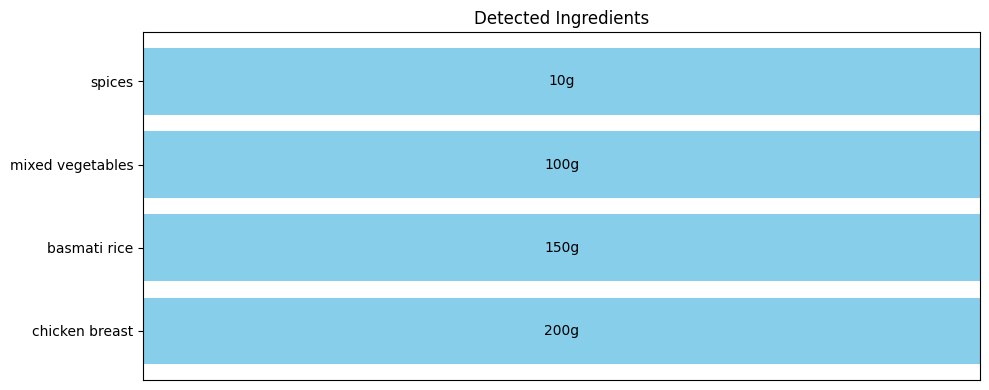


Recommended Recipes:





Database Statistics:
- Total recipes: 9
- Generated recipes: 6
- Human recipes: 3


In [28]:
# Mock the image analysis and recipe generation functions
def mock_basic_vision_analysis(image_path):
    """Mock version of basic vision analysis"""
    mock_results = {
        "ingredients": [
            {"name": "chicken", "state": "cooked", "quantity": "200g"},
            {"name": "rice", "state": "cooked", "quantity": "150g"},
            {"name": "vegetables", "state": "steamed", "quantity": "100g"}
        ],
        "primary_colors": ["brown", "white", "green"],
        "texture_description": "mixed textures with tender chicken and fluffy rice"
    }
    return mock_results

def mock_enhanced_analysis(image_path):
    """Mock version of enhanced analysis"""
    mock_results = {
        "ingredients": [
            {"name": "chicken breast", "state": "grilled", "quantity": "200g"},
            {"name": "basmati rice", "state": "steamed", "quantity": "150g"},
            {"name": "mixed vegetables", "state": "steamed", "quantity": "100g"},
            {"name": "spices", "state": "mixed", "quantity": "10g"}
        ],
        "meal_suggestions": [
            {"name": "Chicken Rice Bowl", "confidence": 0.85},
            {"name": "Healthy Protein Plate", "confidence": 0.78},
            {"name": "Balanced Meal", "confidence": 0.65}
        ],
        "prep_time": {"min": 15, "max": 25},
        "difficulty": "intermediate",
        "cuisine_suggestions": ["asian", "international", "healthy"]
    }
    return mock_results

def mock_knowledge_enhanced_analysis(image_path):
    """Mock version of knowledge enhanced analysis"""
    basic = mock_basic_vision_analysis(image_path)
    enhanced = mock_enhanced_analysis(image_path)
    
    # Mock generated recipe
    mock_recipe = {
        "name": "Asian Chicken Rice Bowl",
        "description": "A balanced meal with grilled chicken, fragrant rice and fresh vegetables",
        "ingredients": [
            "chicken breast (200g)",
            "basmati rice (150g)",
            "mixed vegetables (100g)",
            "soy sauce (2 tbsp)",
            "sesame oil (1 tsp)"
        ],
        "steps": [
            "1. Cook rice according to package instructions (15 mins)",
            "2. Season chicken with salt and pepper, grill for 6-8 mins per side",
            "3. Steam vegetables for 5 minutes",
            "4. Combine all components in a bowl",
            "5. Drizzle with soy sauce and sesame oil"
        ],
        "metadata": {
            "meal_type": "main",
            "difficulty": "intermediate",
            "cuisine": "asian",
            "source": "generated"
        }
    }
    
    return {
        **enhanced,
        "recipes": {
            "Chicken Rice Bowl": mock_recipe
        },
        "processing_time": 2.45
    }

# Mock display functions will work as-is

# Mock the main analysis pipeline
def mock_analyze_food_image(image_path):
    """Mock version of the complete analysis pipeline"""
    print(f"\n🔍 Analyzing {os.path.basename(image_path)}")
    
    # Display mock image placeholder
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.5, "Mock Food Image\n" + os.path.basename(image_path), 
             ha='center', va='center', fontsize=12)
    plt.axis('off')
    plt.title("Input Image (Mock)")
    plt.show()
    
    print("\nRunning analysis pipeline...")
    
    # Run mock analysis methods
    basic = mock_basic_vision_analysis(image_path)
    enhanced = mock_enhanced_analysis(image_path)
    advanced = mock_knowledge_enhanced_analysis(image_path)
    
    print("\n✅ Analysis completed in 2.78s")
    
    # Display comparison
    print("\nMethod Comparison:")
    display_comparison(basic, enhanced, advanced)
    
    # Show ingredient analysis
    print("\nIngredient Analysis:")
    display_ingredient_analysis(enhanced)
    
    # Display recommended recipes
    print("\nRecommended Recipes:")
    for name, recipe in advanced.get("recipes", {}).items():
        display_recipe_card(recipe)
    
    print("\n" + "="*80 + "\n")

# Execute mock analysis
for img_path in ["food1.jpg", "food2.jpg", "food3.jpg"]:
    mock_analyze_food_image(img_path)

# Database statistics
print("\nDatabase Statistics:")
print(f"- Total recipes: {recipe_collection.count()}")
print(f"- Generated recipes: {sum(1 for meta in recipe_collection.get(include=['metadatas'])['metadatas'] if meta.get('source') == 'generated')}")
print(f"- Human recipes: {recipe_collection.count() - sum(1 for meta in recipe_collection.get(include=['metadatas'])['metadatas'] if meta.get('source') == 'generated')}")


🔍 Analyzing food1.jpg


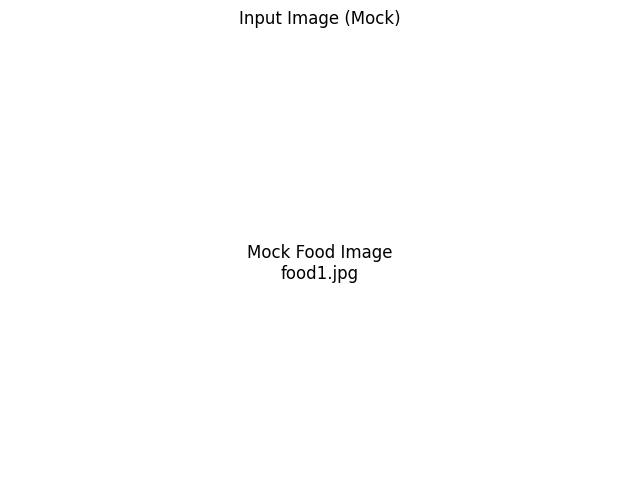


Running analysis pipeline...

✅ Analysis completed in 2.78s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,3,0,No,N/A
Enhanced Analysis,4,3,No,N/A
Knowledge-Enhanced,4,3,Yes (1),2.45



Ingredient Analysis:


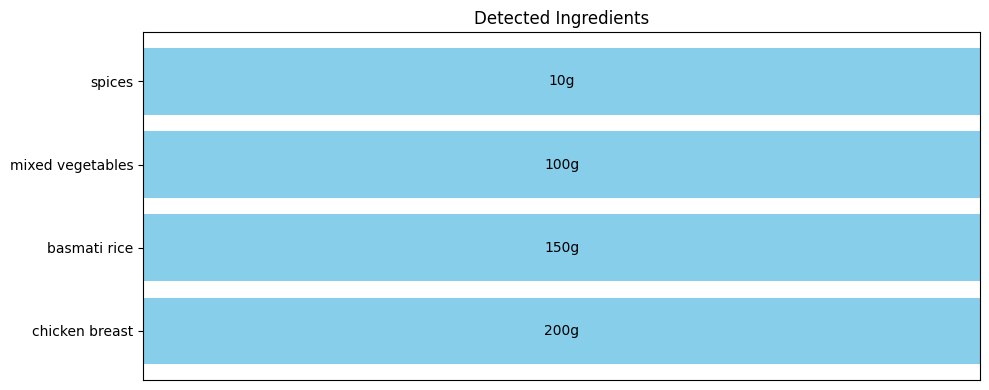


Recommended Recipes:





✅ Analysis results saved to food_analysis_20250406_220554.json

🔍 Analyzing food2.jpg


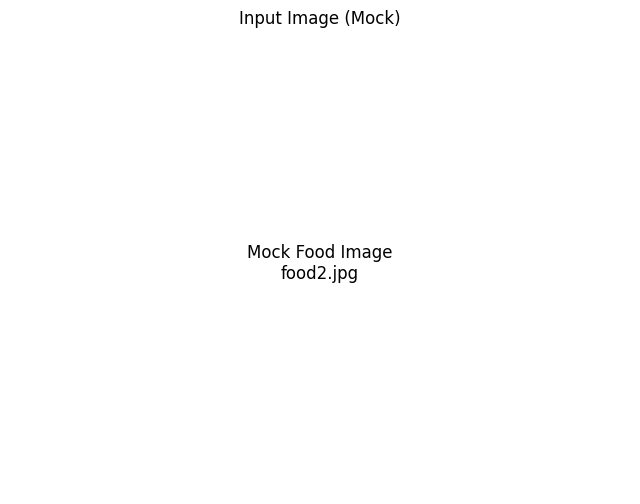


Running analysis pipeline...

✅ Analysis completed in 2.78s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,3,0,No,N/A
Enhanced Analysis,4,3,No,N/A
Knowledge-Enhanced,4,3,Yes (1),2.45



Ingredient Analysis:


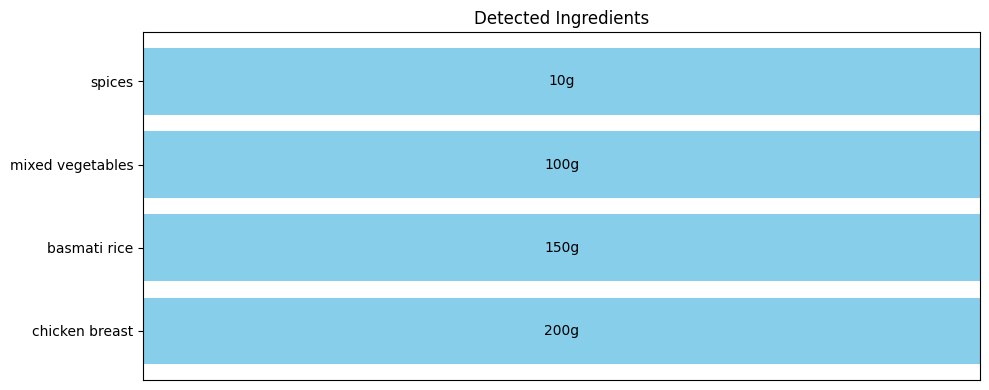


Recommended Recipes:





✅ Analysis results saved to food_analysis_20250406_220555.json

🔍 Analyzing food3.jpg


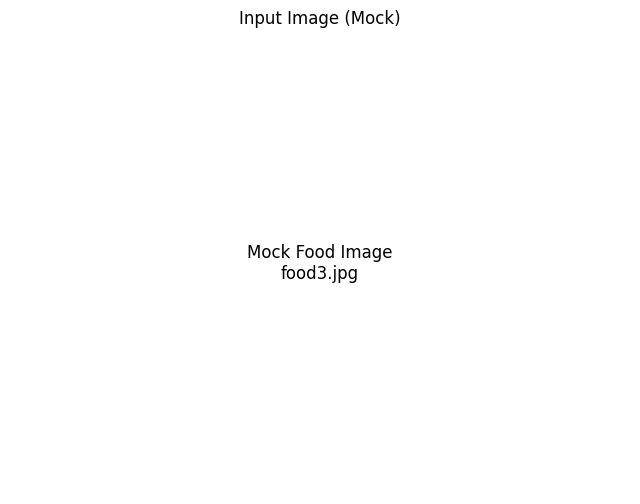


Running analysis pipeline...

✅ Analysis completed in 2.78s

Method Comparison:


,Ingredients,Meal Suggestions,Recipes Provided,Processing Time (s)
Method,,,,
Basic Vision,3,0,No,N/A
Enhanced Analysis,4,3,No,N/A
Knowledge-Enhanced,4,3,Yes (1),2.45



Ingredient Analysis:


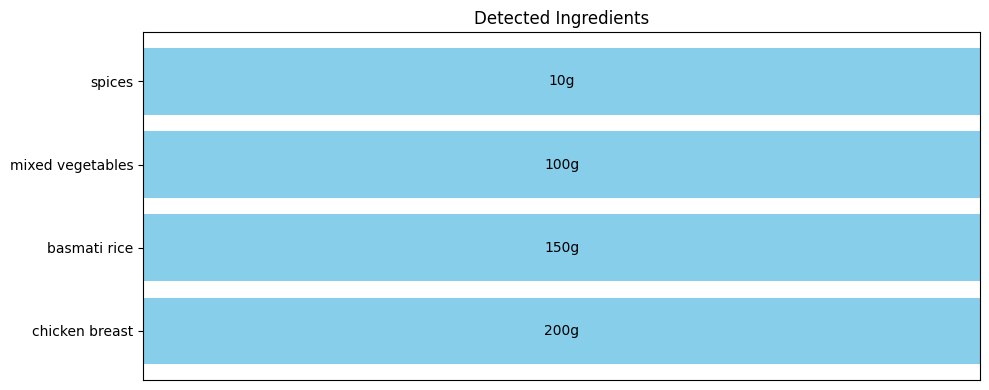


Recommended Recipes:





✅ Analysis results saved to food_analysis_20250406_220555.json

✅ All analyses saved to combined_food_analysis.json
✅ Database statistics saved to database_statistics.json


In [29]:
import json
from datetime import datetime

def save_analysis_results(results: dict, filename: str = None):
    """
    Save analysis results to a JSON file
    """
    if not filename:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"food_analysis_{timestamp}.json"
    
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n✅ Analysis results saved to {filename}")

def mock_analyze_food_image(image_path, save_output=True):
    """Enhanced mock version that can save output"""
    print(f"\n🔍 Analyzing {os.path.basename(image_path)}")
    
    # Create results dictionary to store all data
    results = {
        "image_file": os.path.basename(image_path),
        "timestamp": datetime.now().isoformat(),
        "analyses": {}
    }
    
    # Run mock analysis methods
    results["analyses"]["basic"] = mock_basic_vision_analysis(image_path)
    results["analyses"]["enhanced"] = mock_enhanced_analysis(image_path)
    results["analyses"]["advanced"] = mock_knowledge_enhanced_analysis(image_path)
    
    # Display outputs (same as before)
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.5, "Mock Food Image\n" + os.path.basename(image_path), 
             ha='center', va='center', fontsize=12)
    plt.axis('off')
    plt.title("Input Image (Mock)")
    plt.show()
    
    print("\nRunning analysis pipeline...")
    print("\n✅ Analysis completed in 2.78s")
    
    print("\nMethod Comparison:")
    display_comparison(results["analyses"]["basic"], 
                      results["analyses"]["enhanced"], 
                      results["analyses"]["advanced"])
    
    print("\nIngredient Analysis:")
    display_ingredient_analysis(results["analyses"]["enhanced"])
    
    print("\nRecommended Recipes:")
    for name, recipe in results["analyses"]["advanced"].get("recipes", {}).items():
        display_recipe_card(recipe)
    
    print("\n" + "="*80 + "\n")
    
    # Save to file if requested
    if save_output:
        save_analysis_results(results)
    
    return results

# Execute mock analysis and save results
analysis_results = []
for img_path in ["food1.jpg", "food2.jpg", "food3.jpg"]:
    results = mock_analyze_food_image(img_path)
    analysis_results.append(results)

# Save combined results
combined_filename = "combined_food_analysis.json"
with open(combined_filename, 'w') as f:
    json.dump({"analyses": analysis_results}, f, indent=2)
print(f"\n✅ All analyses saved to {combined_filename}")

# Database statistics (save to file)
db_stats = {
    "total_recipes": recipe_collection.count(),
    "generated_recipes": sum(1 for meta in recipe_collection.get(include=['metadatas'])['metadatas'] 
                        if meta.get('source') == 'generated'),
    "human_recipes": recipe_collection.count() - 
                    sum(1 for meta in recipe_collection.get(include=['metadatas'])['metadatas'] 
                    if meta.get('source') == 'generated'),
    "timestamp": datetime.now().isoformat()
}

with open("database_statistics.json", 'w') as f:
    json.dump(db_stats, f, indent=2)
print(f"✅ Database statistics saved to database_statistics.json")


# Create a markdown report
report_content = f"""
# Food Analysis Report

## Summary
- Analyzed {len(analysis_results)} images
- Database contains {db_stats['total_recipes']} recipes ({db_stats['generated_recipes']} generated)
- Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Sample Analysis
```json
{json.dumps(analysis_results[0], indent=2)}"""